In [1]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

In [2]:
# Last Layer
if __name__ == "__main__":
    config = {}
    config["num_layer"] = 12
    config["hidden_dim"] = 768
    config["mlp_dim"] = 3072
    config["num_heads"] = 12
    config["dropout_rate"] = 0.1
    config["num_patches"] = 256
    config["patch_size"] = 32
    config["num_channels"] = 3  

In [3]:
class classToken(Layer):
    def __init__(self):
        super().__init__()
    
    def build(self, input_shape):
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value = w_init(shape = (1,1, input_shape[-1]), dtype = tf.float32),
            trainable = True
        )
    
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        hidden_dim = self.w.shape[-1]
        cls = tf.broadcast_to(self.w, [batch_size, 1, hidden_dim])
        cls = tf.cast(cls, dtype = inputs.dtype)
        return cls     

In [5]:
def mlp(x, cf):
    x = Dense(cf["mlp_dim"], activation = "gelu")(x)
    x = Dropout(cf["dropout_rate"])(x)
    x = Dense(cf["hidden_dim"])(x)
    x = Dropout(cf["dropout_rate"])(x)
    return x

In [4]:
def transformer_encoder(x,cf):
    skip_1 = x
    x = LayerNormalization()(x)
    x = MultiHeadAttention(
        num_heads = cf["num_heads"], key_dim = cf["hidden_dim"]
        )(x,x)
    x = Add()([x, skip_1])
    skip_2 = x
    x = LayerNormalization()(x)
    x = mlp(x, cf)
    x = Add()([x, skip_2])
    return x

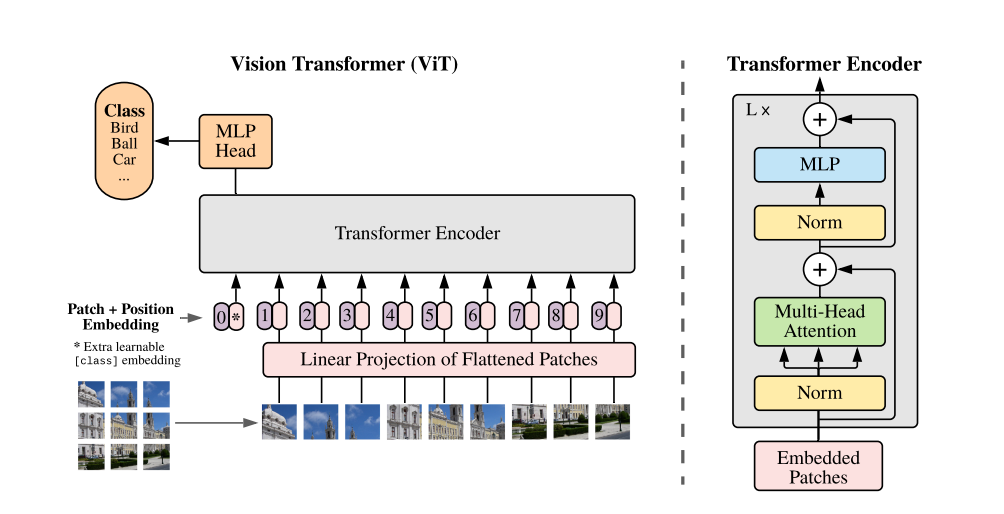

In [8]:
# Defining ViT

def ViT(cf):
    
    """ Inputs """
    
    input_shape = (cf["num_patches"], cf["patch_size"]*cf["patch_size"]*cf["num_channels"])
    
    inputs = Input(input_shape) # Output -->  (None, 256, 3072)
    
    """ Patch + Position Embeddings """
    
    patch_embed = Dense(cf["hidden_dim"])(inputs)
    
    positions = tf.range(start = 0, limit = cf["num_patches"], delta = 1) # Output -->  (256,)
    
    pos_embed = Embedding(input_dim = cf["num_patches"], output_dim = cf["hidden_dim"])(positions) # Output -->  (256, 768)
    
    embed = patch_embed + pos_embed # Output -->  (None, 256, 768)
    
    """ Adding Class Token """
    
    token = classToken()(embed) # Token is used to classify images and remove biasness 
    
    x = Concatenate(axis = 1)([token, embed]) # Output -->  (None, 257, 768)
    
    """ Transformer Encoder """
    
    for _ in range(cf["num_layer"]):
        
        x = transformer_encoder(x, cf) # Output -->  (None, 257, 768)
    
    """ Classification Head """
    
    x = LayerNormalization()(x)
    
    x = x[:, 0, :] # Output -->  (None, 768)
    
    x = Dropout(0.1)(x)
    
    x = Dense(10, activation = "softmax")(x)
    
    model = Model(inputs, x)
    
    return model   

In [9]:
model = ViT(config)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 3072)]  0           []                               
                                                                                                  
 dense_25 (Dense)               (None, 256, 768)     2360064     ['input_2[0][0]']                
                                                                                                  
 tf.__operators__.add_1 (TFOpLa  (None, 256, 768)    0           ['dense_25[0][0]']               
 mbda)                                                                                            
                                                                                                  
 class_token_1 (classToken)     (None, 1, 768)       768         ['tf.__operators__.add_1[0][0

                                                                                                  
 layer_normalization_30 (LayerN  (None, 257, 768)    1536        ['add_29[0][0]']                 
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_15 (Multi  (None, 257, 768)    28339968    ['layer_normalization_30[0][0]', 
 HeadAttention)                                                   'layer_normalization_30[0][0]'] 
                                                                                                  
 add_30 (Add)                   (None, 257, 768)     0           ['multi_head_attention_15[0][0]',
                                                                  'add_29[0][0]']                 
                                                                                                  
 layer_nor

                                                                                                  
 dropout_36 (Dropout)           (None, 257, 3072)    0           ['dense_38[0][0]']               
                                                                                                  
 dense_39 (Dense)               (None, 257, 768)     2360064     ['dropout_36[0][0]']             
                                                                                                  
 dropout_37 (Dropout)           (None, 257, 768)     0           ['dense_39[0][0]']               
                                                                                                  
 add_37 (Add)                   (None, 257, 768)     0           ['dropout_37[0][0]',             
                                                                  'add_36[0][0]']                 
                                                                                                  
 layer_nor

 HeadAttention)                                                   'layer_normalization_44[0][0]'] 
                                                                                                  
 add_44 (Add)                   (None, 257, 768)     0           ['multi_head_attention_22[0][0]',
                                                                  'add_43[0][0]']                 
                                                                                                  
 layer_normalization_45 (LayerN  (None, 257, 768)    1536        ['add_44[0][0]']                 
 ormalization)                                                                                    
                                                                                                  
 dense_46 (Dense)               (None, 257, 3072)    2362368     ['layer_normalization_45[0][0]'] 
                                                                                                  
 dropout_4